# **📦 Step 1: Install & Import Dependencies**

Before diving into the project, we need to make sure all the required libraries are available.  
- If you're running this on **Google Colab**, the `pip install` command will fetch the correct versions of `albumentations`, `opencv`, and `scikit-learn`.  
- If you're working locally and already have these installed, you can skip the installation line.  

We then import all the essential packages:  
- **Core utilities**: `os`, `glob`, `random`, and `Path` for handling files and directories.  
- **Numerical & visualization tools**: `numpy`, `cv2` (OpenCV), and `matplotlib`.  
- **PyTorch**: for building and training our deep learning model.  
- **Albumentations**: a powerful image augmentation library (with `ToTensorV2` for PyTorch compatibility).  
- **scikit-learn**: for evaluation metrics such as ROC-AUC.  
- **tqdm**: for progress bars during training/evaluation.  


In [ ]:
# If on Colab, run this cell. If local & deps installed, you can skip the pip lines.
!pip -q install albumentations==1.4.4 opencv-python==4.10.0.84 scikit-learn==1.5.1

import os, glob, random
from pathlib import Path

import numpy as np
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.metrics import roc_auc_score
from tqdm import tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.4/150.4 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 109.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.1 which is incompatible.


# **⚙️ Step 2: Define Paths, Hyperparameters & Reproducibility**

In this step, we set up the **core configuration** for our segmentation project:

- **Data paths**: Pointing to training and testing images and masks.  
- **Hyperparameters**:  
  - `IMG_SIZE`: The resolution to resize all images and masks (512×512).  
  - `BATCH_SIZE`: Number of samples processed per iteration (set to 4 for memory efficiency).  
  - `LR`: Learning rate for optimization (1e-4, a common choice for segmentation tasks).  
  - `EPOCHS`: Number of training epochs (100).  
- **Normalization**: Since we’re working with grayscale X-rays, we normalize pixel values with mean = 0.5 and std = 0.5.  
- **Device**: Automatically selects **GPU (CUDA)** if available, otherwise falls back to CPU.  
- **Random seed**: Ensures reproducibility by fixing seeds for Python, NumPy, and PyTorch.  

Finally, we validate that the dataset directories exist and print out which device will be used for training.  


In [ ]:

DATA_DIR = "/content/drive/MyDrive/Data"

TRAIN_IMG_DIR = os.path.join(DATA_DIR, "train", "image")
TRAIN_MSK_DIR = os.path.join(DATA_DIR, "train", "mask")
TEST_IMG_DIR  = os.path.join(DATA_DIR, "test",  "image")
TEST_MSK_DIR  = os.path.join(DATA_DIR, "test",  "mask")

IMG_SIZE   = 512
BATCH_SIZE = 4
LR         = 1e-4
EPOCHS     = 100

MEAN = (0.5,)  # grayscale normalization
STD  = (0.5,)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(SEED)

for p in [TRAIN_IMG_DIR, TRAIN_MSK_DIR, TEST_IMG_DIR, TEST_MSK_DIR]:
    assert os.path.isdir(p), f"Folder not found: {p}"

print(f"Using device: {DEVICE}")


Using device: cuda


# **🖇️ Step 3: Match Images with Masks**

Since this is an **image segmentation task**, every image should have a corresponding mask.  
This function `get_pairs` takes care of pairing them correctly:

- **Process**:  
  - Collect all image and mask file paths.  
  - Sort them to keep a consistent order.  
  - Use the file stem (name without extension) to match images with their corresponding masks.  

- **Checks**:  
  - Prints the number of images, masks, and successfully matched pairs.  
  - Warns if some images are missing masks (and shows the first few as a sample).  

- **Output**:  
  - `train_pairs`: List of `(image_path, mask_path)` pairs for training.  
  - `test_pairs`: List of `(image_path, mask_path)` pairs for testing.  

This ensures our dataset is well-structured before moving forward.  


In [ ]:
def get_pairs(img_dir, mask_dir):
    imgs = sorted([p for p in glob.glob(os.path.join(img_dir, "*")) if os.path.isfile(p)])
    msks = sorted([p for p in glob.glob(os.path.join(mask_dir, "*")) if os.path.isfile(p)])
    m_map = {Path(p).stem: p for p in msks}

    pairs, missing = [], []
    for ip in imgs:
        key = Path(ip).stem
        mp = m_map.get(key, None)
        (pairs.append((ip, mp)) if mp else missing.append(ip))

    print(f"Images: {len(imgs)}, Masks: {len(msks)}, Matched pairs: {len(pairs)}")
    if missing:
        print("WARNING: masks missing for some images (showing first 5):")
        print("\n".join(missing[:5]))
    return pairs

train_pairs = get_pairs(TRAIN_IMG_DIR, TRAIN_MSK_DIR)
test_pairs  = get_pairs(TEST_IMG_DIR,  TEST_MSK_DIR)
print(f"\nTotals -> Train: {len(train_pairs)} | Test: {len(test_pairs)}")


Images: 80, Masks: 80, Matched pairs: 80
Images: 20, Masks: 20, Matched pairs: 20

Totals -> Train: 80 | Test: 20


# **🧩 Step 4: Custom Dataset & Preprocessing**

Now we prepare our dataset class and preprocessing pipeline tailored for **retinal vessel segmentation**:

### 🔬 Green Channel + CLAHE
- Retinal vessels are most visible in the **green channel** of fundus images.  
- We apply **CLAHE (Contrast Limited Adaptive Histogram Equalization)** to the green channel.  
  - This improves local contrast.  
  - Makes vessels more distinguishable from the background.  

### 📂 `RetinaVesselDataset` Class
A custom PyTorch `Dataset` to load and preprocess our data:
- **Input**: `(image_path, mask_path)` pairs.  
- **Image preprocessing**:
  - Read image in **BGR** format.  
  - Extract green channel and enhance contrast using CLAHE.  
  - Expand dimensions to `[H, W, 1]` for Albumentations compatibility.  
- **Mask preprocessing**:
  - Read as grayscale.  
  - Binarize to `{0,1}` (vessels vs. background).  
  - Expand dimensions to `[H, W, 1]`.  
- **Transformations**:
  - If Albumentations transforms are provided, apply them to both image and mask.  
  - Otherwise, convert to PyTorch tensors manually.  
- **Output**:  
  - `image`: FloatTensor of shape `[1, H, W]`, normalized to `[0,1]`.  
  - `mask`: FloatTensor of shape `[1, H, W]`, with values `{0,1}`.  

This dataset ensures images and masks are preprocessed consistently, making them ready for training.  


In [ ]:
def green_channel_clahe(bgr_img, clip_limit=2.0, tile_grid_size=(8,8)):
    """
    Extract green channel and apply CLAHE to boost vessel contrast.
    Input: BGR uint8 image (cv2.imread default).
    Output: uint8 2D image (H,W)
    """
    g = bgr_img[..., 1]  # green channel
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    g_eq = clahe.apply(g)
    return g_eq

class RetinaVesselDataset(Dataset):
    """
    Returns:
      image: FloatTensor [1,H,W], normalized
      mask : FloatTensor [1,H,W] in {0,1}
    """
    def __init__(self, pairs, transform=None):
        self.pairs = pairs
        self.transform = transform

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_path, msk_path = self.pairs[idx]
        bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)
        msk = cv2.imread(msk_path, cv2.IMREAD_GRAYSCALE)

        if bgr is None: raise FileNotFoundError(img_path)
        if msk is None: raise FileNotFoundError(msk_path)

        # Preprocess image: green channel + CLAHE (uint8)
        img = green_channel_clahe(bgr)

        # Binarize mask to {0,1}
        msk = (msk > 127).astype(np.float32)

        # Expand channel dim to HxWx1 for Albumentations
        img = np.expand_dims(img, axis=-1)  # uint8
        msk = np.expand_dims(msk, axis=-1)  # float32 {0,1}

        if self.transform:
            aug = self.transform(image=img, mask=msk)
            img_t = aug["image"]   # [1,H,W] float
            msk_t = aug["mask"]    # [1,H,W] float
        else:
            img_t = torch.from_numpy(img.transpose(2,0,1)).float() / 255.0
            msk_t = torch.from_numpy(msk.transpose(2,0,1)).float()

        # Safety: clamp mask to {0,1}
        msk_t = (msk_t > 0.5).float()
        return img_t, msk_t


# **🎨 Step 5: Data Augmentation & Visualization**

To improve model generalization, we apply **data augmentations** during training. Since retinal vessels are very thin and delicate, we keep transformations mild and careful.

### 🛠️ Training Augmentations
- **Resize**: All images and masks resized to `IMG_SIZE × IMG_SIZE` (512×512).  
- **Flips**: Horizontal (50% chance) and vertical (20% chance).  
- **Shift, Scale, Rotate**: Small translations, zooms, and rotations for robustness.  
- **Brightness/Contrast**: To mimic different lighting conditions.  
- **Gaussian Blur**: Slight blur to simulate imaging variations.  
- **Normalization**: Using predefined `MEAN` and `STD`.  
- **ToTensorV2**: Convert NumPy arrays to PyTorch tensors.

### 🧪 Testing Augmentations
For test data, we only **resize** and **normalize**, ensuring evaluation remains consistent without artificial randomness.

### 📂 Dataset & DataLoader
- `train_ds` and `test_ds`: Custom dataset objects with augmentations applied.  
- `train_loader` and `test_loader`: DataLoaders for efficient mini-batch processing.

### 👀 Visualizing Samples
We use the helper function `show_samples` to:
1. Display the preprocessed image (Green channel + CLAHE).  
2. Show the corresponding binary mask.  
3. Overlay the mask on the image for quick verification.

This helps confirm that augmentations and preprocessing are correctly applied before training.  


Final -> Train batches: 20, Test batches: 5


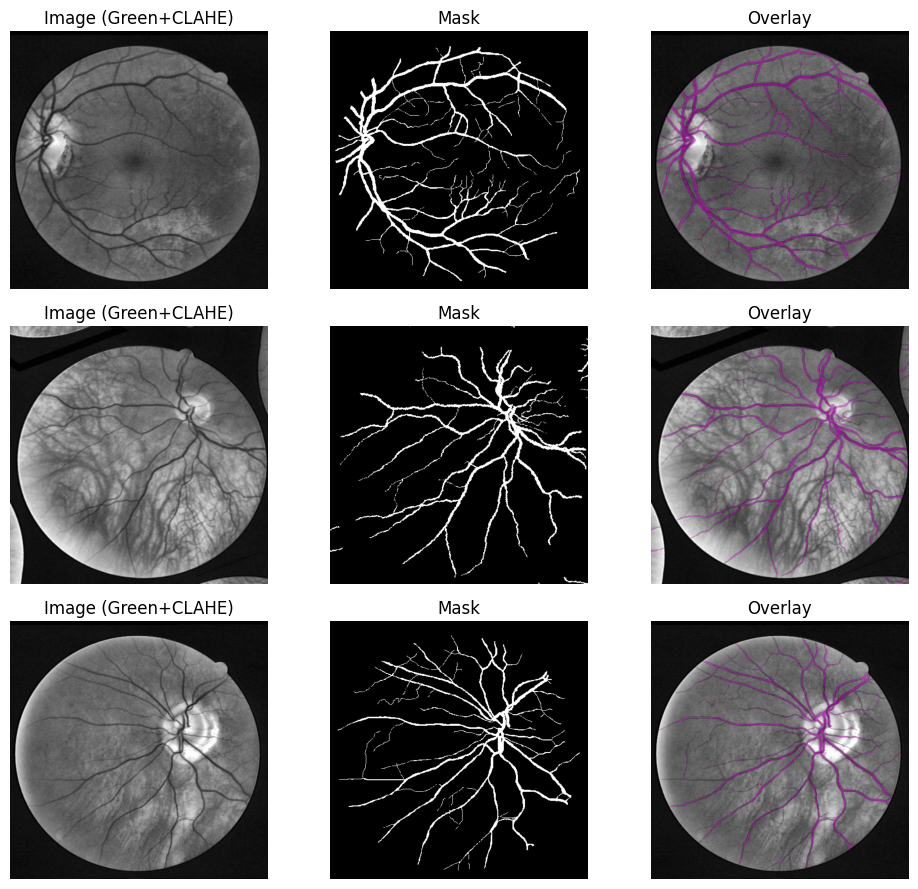

In [ ]:
# Augmentations: keep geometric mild (thin vessels)
train_tfms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.03, scale_limit=0.05, rotate_limit=10,
                       border_mode=cv2.BORDER_REFLECT_101, p=0.5),
    A.RandomBrightnessContrast(p=0.25),
    A.GaussianBlur(blur_limit=(3, 5), p=0.15),
    A.Normalize(mean=MEAN, std=STD, max_pixel_value=255.0),
    ToTensorV2(transpose_mask=True),
])

test_tfms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=MEAN, std=STD, max_pixel_value=255.0),
    ToTensorV2(transpose_mask=True),
])

train_ds = RetinaVesselDataset(train_pairs, transform=train_tfms)
test_ds  = RetinaVesselDataset(test_pairs,  transform=test_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"Final -> Train batches: {len(train_loader)}, Test batches: {len(test_loader)}")

def denorm_img(t):
    out = t.clone()
    out = out * STD[0] + MEAN[0]
    return torch.clamp(out, 0, 1)

def show_samples(ds, n=3):
    import numpy as np
    idxs = random.sample(range(len(ds)), k=min(n, len(ds)))
    fig, axes = plt.subplots(len(idxs), 3, figsize=(10, 3*len(idxs)))
    if len(idxs) == 1: axes = np.expand_dims(axes, 0)
    for r, i in enumerate(idxs):
        x, y = ds[i]
        img = denorm_img(x[0]).cpu().numpy()
        msk = y[0].cpu().numpy()
        axes[r,0].imshow(img, cmap="gray"); axes[r,0].set_title("Image (Green+CLAHE)"); axes[r,0].axis("off")
        axes[r,1].imshow(msk, cmap="gray"); axes[r,1].set_title("Mask"); axes[r,1].axis("off")
        axes[r,2].imshow(img, cmap="gray"); axes[r,2].imshow(np.ma.masked_where(msk==0, msk), alpha=0.4, cmap="spring")
        axes[r,2].set_title("Overlay"); axes[r,2].axis("off")
    plt.tight_layout(); plt.show()

# Peek a few training samples
show_samples(train_ds, n=3)


# **🧠 Step 6: Attention U-Net Architecture**

To segment thin retinal vessels accurately, we use an **Attention U-Net**.  
This is an extension of the standard U-Net that integrates **attention gates** to focus on relevant spatial regions.

### 🔑 Building Blocks
1. **DoubleConv**: Two consecutive convolution layers with BatchNorm + ReLU.  
   - Extracts and refines features.  
2. **Down**: MaxPooling followed by `DoubleConv`.  
   - Reduces spatial dimensions (encoder path).  
3. **AttentionBlock**:  
   - Takes two inputs:  
     - `g`: Gating signal from the decoder (coarse, high-level features).  
     - `x`: Skip connection from the encoder (fine details).  
   - Learns where to "pay attention" in the skip connection, suppressing irrelevant regions.  
4. **UpAttn**:  
   - Upsamples the decoder output using transposed convolution.  
   - Applies **attention** to the corresponding skip connection.  
   - Concatenates and refines features with `DoubleConv`.  
5. **AttnUNet** (the full model):  
   - Encoder: progressively downsamples input to extract features.  
   - Bottleneck: deepest representation at the bottom.  
   - Decoder: upsamples with attention-enhanced skip connections.  
   - Final `1×1 Conv`: Produces segmentation logits (`[B,1,H,W]`).  

### 🧾 Summary
- Input: **1-channel grayscale** (green-channel fundus images).  
- Output: **1-channel binary mask** (vessels vs background).  
- Benefit of attention: Helps the network focus on **tiny vessels** while ignoring irrelevant structures.  


In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.net(x)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.conv = DoubleConv(in_ch, out_ch)
    def forward(self, x):
        return self.conv(self.pool(x))

class AttentionBlock(nn.Module):
    """
    g: gating signal from decoder
    x: skip connection from encoder
    """
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1  = self.W_g(g)
        x1  = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class UpAttn(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up   = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)
        self.attn = AttentionBlock(F_g=out_ch, F_l=out_ch, F_int=out_ch // 2)
        self.conv = DoubleConv(in_ch=out_ch*2, out_ch=out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)  # upsample (channels -> out_ch)
        # Adjust size if needed
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = nn.functional.pad(x1, [diffX//2, diffX - diffX//2,
                                    diffY//2, diffY - diffY//2])

        # Attention gate on the skip
        x2_att = self.attn(x1, x2)
        x = torch.cat([x2_att, x1], dim=1)
        return self.conv(x)

class AttnUNet(nn.Module):
    def __init__(self, in_ch=1, out_ch=1, features=(64,128,256,512)):
        super().__init__()
        f1, f2, f3, f4 = features
        self.inc   = DoubleConv(in_ch, f1)
        self.down1 = Down(f1, f2)
        self.down2 = Down(f2, f3)
        self.down3 = Down(f3, f4)
        self.bottom = DoubleConv(f4, f4*2)            # 1024

        self.up1 = UpAttn(f4*2, f4)                   # 1024->512
        self.up2 = UpAttn(f4,   f3)                   # 512->256
        self.up3 = UpAttn(f3,   f2)                   # 256->128
        self.up4 = UpAttn(f2,   f1)                   # 128->64

        self.outc = nn.Conv2d(f1, out_ch, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)       # 64
        x2 = self.down1(x1)    # 128
        x3 = self.down2(x2)    # 256
        x4 = self.down3(x3)    # 512
        xb = self.bottom(x4)   # 1024

        x  = self.up1(xb, x4)
        x  = self.up2(x,  x3)
        x  = self.up3(x,  x2)
        x  = self.up4(x,  x1)
        return self.outc(x)    # logits [B,1,H,W]


# **📊 Step 7: Loss Function & Evaluation Metrics**

For thin retinal vessels, the dataset is highly **imbalanced** (few vessel pixels vs. many background pixels).  
To handle this, we use a **specialized loss** and multiple evaluation metrics.

---

### 🎯 Focal Tversky Loss
- **Why?** Traditional Dice or Cross-Entropy struggle with severe imbalance.  
- **Tversky Index (TI)**: Balances contributions of false positives and false negatives.  
- **Loss**: Adds a focal effect to concentrate on harder-to-classify pixels.  
- **Parameters**:
  - α (0.7): penalizes false positives less  
  - β (0.3): penalizes false negatives more (important for vessels)  
  - γ (0.85): adds focal effect for difficult pixels  

---

### 📏 Metrics (Thresholded at 0.5)
- **Dice Coefficient**: Measures overlap between prediction and ground truth (similar to F1-score).  
- **IoU (Jaccard Index)**: Intersection over Union, stricter than Dice.  
- **Pixel Accuracy**: Percentage of correctly classified pixels.  
- **Sensitivity (Recall)**: Ability to detect vessel pixels.  
- **Specificity**: Ability to detect background pixels.  
- **AUC (ROC-AUC)**: Area under ROC curve, threshold-independent measure of separability.  

---

✅ Together, these metrics provide a **comprehensive evaluation** of segmentation performance.  
- **Dice/IoU** → Overlap quality  
- **Sensitivity/Specificity** → Vessel vs. background balance  
- **AUC** → Global discriminative ability  


In [ ]:
class FocalTverskyLoss(nn.Module):
    """
    Focal Tversky (for imbalanced thin vessels):
    TI = TP / (TP + α*FP + β*FN);  Loss = (1 - TI)^γ
    """
    def __init__(self, alpha=0.7, beta=0.3, gamma=0.85, eps=1e-7):
        super().__init__()
        self.alpha = alpha
        self.beta  = beta
        self.gamma = gamma
        self.eps   = eps

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        # Flatten
        probs_flat   = probs.view(-1)
        targets_flat = targets.view(-1)

        TP = (probs_flat * targets_flat).sum()
        FP = (probs_flat * (1 - targets_flat)).sum()
        FN = ((1 - probs_flat) * targets_flat).sum()

        TI = (TP + self.eps) / (TP + self.alpha*FP + self.beta*FN + self.eps)
        loss = torch.pow((1 - TI), self.gamma)
        return loss

# ---- Metrics (thresholded at 0.5) ----
@torch.no_grad()
def dice_coef(logits, targets, eps=1e-7):
    probs = torch.sigmoid(logits)
    preds = (probs > 0.5).float()
    inter = (preds * targets).sum(dim=(1,2,3))
    union = preds.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3))
    dice  = (2*inter + eps) / (union + eps)
    return dice.mean().item()

@torch.no_grad()
def iou_score(logits, targets, eps=1e-7):
    probs = torch.sigmoid(logits)
    preds = (probs > 0.5).float()
    inter = (preds * targets).sum(dim=(1,2,3))
    union = preds.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3)) - inter
    iou   = (inter + eps) / (union + eps)
    return iou.mean().item()

@torch.no_grad()
def pixel_accuracy(logits, targets):
    probs = torch.sigmoid(logits)
    preds = (probs > 0.5).float()
    return (preds == targets).float().mean().item()

@torch.no_grad()
def sensitivity_specificity(logits, targets, eps=1e-7):
    probs = torch.sigmoid(logits)
    preds = (probs > 0.5).float()
    tp = (preds * targets).sum().item()
    tn = ((1 - preds) * (1 - targets)).sum().item()
    fp = (preds * (1 - targets)).sum().item()
    fn = (((1 - preds) * targets)).sum().item()
    sens = tp / (tp + fn + eps)  # recall
    spec = tn / (tn + fp + eps)
    return sens, spec

@torch.no_grad()
def auc_score(logits, targets):
    # Flatten probs/targets for AUC
    probs = torch.sigmoid(logits).detach().cpu().numpy().ravel()
    targs = targets.detach().cpu().numpy().ravel()
    # Handle degenerate batch (all 0s or all 1s)
    if np.all(targs == 0) or np.all(targs == 1):
        return np.nan
    try:
        return roc_auc_score(targs, probs)
    except Exception:
        return np.nan


# **🚀 Step 8: Training & Evaluation Loop**

Now we set up the **training pipeline** for our Attention U-Net model.  
This includes functions for **one training epoch**, **evaluation**, and the main **epoch loop**.

---

### 🔁 Training Function (`train_one_epoch`)
- Runs the model in **training mode**.  
- For each batch:
  - Forward pass → predictions (`logits`).  
  - Compute loss using **Focal Tversky Loss**.  
  - Backpropagation + weight update via `AdamW`.  
- Tracks and averages metrics across batches:  
  - Loss  
  - Dice Coefficient  
  - IoU  
  - Pixel Accuracy  

---

### 🧪 Evaluation Function (`eval_epoch`)
- Runs the model in **evaluation mode** (no gradients).  
- For each batch:
  - Forward pass → compute loss & metrics.  
  - Adds **AUC score** (if valid).  
- Returns average values for:
  - Loss  
  - Dice  
  - IoU  
  - Accuracy  
  - AUC  

---

### ⚙️ Model Setup
- **Model**: `AttnUNet` with input/output channels = 1.  
- **Optimizer**: AdamW with weight decay (`1e-4`).  
- **Loss Function**: Focal Tversky Loss (α=0.7, β=0.3, γ=0.75).  

---

### 📈 Training Loop
- Runs for a fixed number of epochs.  
- Logs metrics for **train & test sets**.  
- Saves the **best model checkpoint** (based on test Dice score) as:


In [ ]:
def train_one_epoch(model, loader, optimizer, loss_fn):
    model.train()
    tot_loss = tot_dice = tot_iou = tot_acc = 0.0
    pbar = tqdm(loader, desc="Train", leave=False)
    for imgs, masks in pbar:
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        optimizer.zero_grad()
        logits = model(imgs)
        loss = loss_fn(logits, masks)
        loss.backward()
        optimizer.step()

        # Metrics
        d = dice_coef(logits, masks)
        i = iou_score(logits, masks)
        a = pixel_accuracy(logits, masks)

        tot_loss += loss.item()
        tot_dice += d
        tot_iou  += i
        tot_acc  += a
        pbar.set_postfix(loss=loss.item(), dice=d, iou=i, acc=a)

    n = len(loader)
    return (tot_loss/n, tot_dice/n, tot_iou/n, tot_acc/n)

@torch.no_grad()
def eval_epoch(model, loader, loss_fn):
    model.eval()
    tot_loss = tot_dice = tot_iou = tot_acc = 0.0
    aucs = []
    for imgs, masks in loader:
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        logits = model(imgs)
        loss = loss_fn(logits, masks)

        d = dice_coef(logits, masks)
        i = iou_score(logits, masks)
        a = pixel_accuracy(logits, masks)
        auc = auc_score(logits, masks)

        tot_loss += loss.item()
        tot_dice += d
        tot_iou  += i
        tot_acc  += a
        if not np.isnan(auc):
            aucs.append(auc)

    n = len(loader)
    mean_auc = float(np.mean(aucs)) if aucs else float("nan")
    return (tot_loss/n, tot_dice/n, tot_iou/n, tot_acc/n, mean_auc)

# ---- Model / Optim / Loss ----
model = AttnUNet(in_ch=1, out_ch=1).to(DEVICE)
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
loss_fn = FocalTverskyLoss(alpha=0.7, beta=0.3, gamma=0.75)

best_test_dice = -1.0
history = {"train_loss":[], "train_dice":[], "test_loss":[], "test_dice":[]}

for epoch in range(1, EPOCHS+1):
    tr_loss, tr_dice, tr_iou, tr_acc = train_one_epoch(model, train_loader, optimizer, loss_fn)
    te_loss, te_dice, te_iou, te_acc, te_auc = eval_epoch(model, test_loader, loss_fn)

    history["train_loss"].append(tr_loss)
    history["train_dice"].append(tr_dice)
    history["test_loss"].append(te_loss)
    history["test_dice"].append(te_dice)

    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"Train: loss={tr_loss:.4f}, dice={tr_dice:.4f}, iou={tr_iou:.4f}, acc={tr_acc:.4f} | "
          f"Test:  loss={te_loss:.4f}, dice={te_dice:.4f}, iou={te_iou:.4f}, acc={te_acc:.4f}, auc={te_auc:.4f}")

    if te_dice > best_test_dice:
        best_test_dice = te_dice
        torch.save(model.state_dict(), "best_attnunet.pth")
        print("  ✅ Saved new best model (by Test Dice) -> best_attnunet.pth")



Epoch 01/100 | Train: loss=0.8517, dice=0.3697, iou=0.2319, acc=0.6933 | Test:  loss=0.9095, dice=0.0000, iou=0.0000, acc=0.9126, auc=0.7558
  ✅ Saved new best model (by Test Dice) -> best_attnunet.pth


Epoch 02/100 | Train: loss=0.8092, dice=0.5393, iou=0.3725, acc=0.8606 | Test:  loss=0.8090, dice=0.6865, iou=0.5232, acc=0.9387, auc=0.9391
  ✅ Saved new best model (by Test Dice) -> best_attnunet.pth


Epoch 03/100 | Train: loss=0.7932, dice=0.6017, iou=0.4334, acc=0.8948 | Test:  loss=0.7770, dice=0.6566, iou=0.4898, acc=0.9179, auc=0.9669


Epoch 04/100 | Train: loss=0.7820, dice=0.6377, iou=0.4715, acc=0.9086 | Test:  loss=0.7753, dice=0.6471, iou=0.4795, acc=0.9108, auc=0.9743


Epoch 05/100 | Train: loss=0.7724, dice=0.6537, iou=0.4884, acc=0.9140 | Test:  loss=0.7661, dice=0.6719, iou=0.5068, acc=0.9206, auc=0.9747


Epoch 06/100 | Train: loss=0.7658, dice=0.6728, iou=0.5089, acc=0.9225 | Test:  loss=0.7568, dice=0.7073, iou=0.5479, acc=0.9335, auc=0.9764
  ✅ Saved new best model (by Test Dice) -> best_attnunet.pth


Epoch 07/100 | Train: loss=0.7596, dice=0.6831, iou=0.5212, acc=0.9268 | Test:  loss=0.7475, dice=0.6873, iou=0.5244, acc=0.9259, auc=0.9781


Epoch 08/100 | Train: loss=0.7513, dice=0.6906, iou=0.5290, acc=0.9287 | Test:  loss=0.7417, dice=0.7258, iou=0.5703, acc=0.9393, auc=0.9793
  ✅ Saved new best model (by Test Dice) -> best_attnunet.pth


Epoch 09/100 | Train: loss=0.7444, dice=0.7109, iou=0.5529, acc=0.9357 | Test:  loss=0.7336, dice=0.7234, iou=0.5675, acc=0.9384, auc=0.9787


Epoch 10/100 | Train: loss=0.7370, dice=0.7126, iou=0.5554, acc=0.9357 | Test:  loss=0.7292, dice=0.7189, iou=0.5620, acc=0.9366, auc=0.9795


Epoch 11/100 | Train: loss=0.7295, dice=0.7253, iou=0.5703, acc=0.9402 | Test:  loss=0.7216, dice=0.7375, iou=0.5848, acc=0.9428, auc=0.9786
  ✅ Saved new best model (by Test Dice) -> best_attnunet.pth


Epoch 12/100 | Train: loss=0.7217, dice=0.7267, iou=0.5720, acc=0.9407 | Test:  loss=0.7167, dice=0.7391, iou=0.5868, acc=0.9435, auc=0.9788
  ✅ Saved new best model (by Test Dice) -> best_attnunet.pth


Epoch 13/100 | Train: loss=0.7146, dice=0.7367, iou=0.5843, acc=0.9440 | Test:  loss=0.7036, dice=0.7461, iou=0.5957, acc=0.9454, auc=0.9807
  ✅ Saved new best model (by Test Dice) -> best_attnunet.pth


Epoch 14/100 | Train: loss=0.7073, dice=0.7404, iou=0.5892, acc=0.9450 | Test:  loss=0.7004, dice=0.7546, iou=0.6064, acc=0.9481, auc=0.9805
  ✅ Saved new best model (by Test Dice) -> best_attnunet.pth


Epoch 15/100 | Train: loss=0.6998, dice=0.7449, iou=0.5950, acc=0.9464 | Test:  loss=0.6870, dice=0.7649, iou=0.6199, acc=0.9512, auc=0.9810
  ✅ Saved new best model (by Test Dice) -> best_attnunet.pth


Epoch 16/100 | Train: loss=0.6915, dice=0.7519, iou=0.6035, acc=0.9486 | Test:  loss=0.6822, dice=0.7900, iou=0.6531, acc=0.9595, auc=0.9787
  ✅ Saved new best model (by Test Dice) -> best_attnunet.pth


Epoch 17/100 | Train: loss=0.6824, dice=0.7549, iou=0.6077, acc=0.9492 | Test:  loss=0.6763, dice=0.7655, iou=0.6206, acc=0.9514, auc=0.9796


Epoch 18/100 | Train: loss=0.6744, dice=0.7619, iou=0.6164, acc=0.9515 | Test:  loss=0.6810, dice=0.7806, iou=0.6407, acc=0.9611, auc=0.9630


Epoch 19/100 | Train: loss=0.6645, dice=0.7669, iou=0.6228, acc=0.9524 | Test:  loss=0.6585, dice=0.7602, iou=0.6137, acc=0.9499, auc=0.9795


Epoch 20/100 | Train: loss=0.6573, dice=0.7699, iou=0.6267, acc=0.9540 | Test:  loss=0.6455, dice=0.7814, iou=0.6416, acc=0.9564, auc=0.9793


Epoch 21/100 | Train: loss=0.6480, dice=0.7766, iou=0.6356, acc=0.9556 | Test:  loss=0.6395, dice=0.7812, iou=0.6413, acc=0.9560, auc=0.9793


Epoch 22/100 | Train: loss=0.6375, dice=0.7798, iou=0.6397, acc=0.9563 | Test:  loss=0.6345, dice=0.7933, iou=0.6577, acc=0.9600, auc=0.9774
  ✅ Saved new best model (by Test Dice) -> best_attnunet.pth


Epoch 23/100 | Train: loss=0.6302, dice=0.7826, iou=0.6435, acc=0.9575 | Test:  loss=0.6267, dice=0.7851, iou=0.6467, acc=0.9575, auc=0.9796


Epoch 24/100 | Train: loss=0.6230, dice=0.7817, iou=0.6425, acc=0.9577 | Test:  loss=0.6209, dice=0.7671, iou=0.6228, acc=0.9517, auc=0.9807


Epoch 25/100 | Train: loss=0.6121, dice=0.7862, iou=0.6484, acc=0.9588 | Test:  loss=0.6020, dice=0.8010, iou=0.6682, acc=0.9628, auc=0.9783
  ✅ Saved new best model (by Test Dice) -> best_attnunet.pth


Epoch 26/100 | Train: loss=0.6018, dice=0.7910, iou=0.6549, acc=0.9600 | Test:  loss=0.5967, dice=0.7866, iou=0.6487, acc=0.9580, auc=0.9758


Epoch 27/100 | Train: loss=0.5930, dice=0.7903, iou=0.6540, acc=0.9598 | Test:  loss=0.5861, dice=0.7980, iou=0.6641, acc=0.9611, auc=0.9805


Epoch 28/100 | Train: loss=0.5831, dice=0.7959, iou=0.6617, acc=0.9614 | Test:  loss=0.5761, dice=0.8037, iou=0.6719, acc=0.9630, auc=0.9804
  ✅ Saved new best model (by Test Dice) -> best_attnunet.pth


Epoch 29/100 | Train: loss=0.5746, dice=0.7950, iou=0.6605, acc=0.9613 | Test:  loss=0.5686, dice=0.8086, iou=0.6790, acc=0.9659, auc=0.9741
  ✅ Saved new best model (by Test Dice) -> best_attnunet.pth


Epoch 30/100 | Train: loss=0.5648, dice=0.7987, iou=0.6655, acc=0.9624 | Test:  loss=0.5607, dice=0.8013, iou=0.6686, acc=0.9623, auc=0.9781


Epoch 31/100 | Train: loss=0.5562, dice=0.7992, iou=0.6661, acc=0.9627 | Test:  loss=0.5509, dice=0.7936, iou=0.6582, acc=0.9600, auc=0.9788


Epoch 32/100 | Train: loss=0.5468, dice=0.8015, iou=0.6693, acc=0.9633 | Test:  loss=0.5461, dice=0.8019, iou=0.6695, acc=0.9629, auc=0.9774


Epoch 33/100 | Train: loss=0.5404, dice=0.7979, iou=0.6646, acc=0.9627 | Test:  loss=0.5430, dice=0.7973, iou=0.6632, acc=0.9611, auc=0.9758


Epoch 34/100 | Train: loss=0.5319, dice=0.8012, iou=0.6690, acc=0.9638 | Test:  loss=0.5242, dice=0.8073, iou=0.6771, acc=0.9667, auc=0.9702


Epoch 35/100 | Train: loss=0.5209, dice=0.8035, iou=0.6722, acc=0.9643 | Test:  loss=0.5108, dice=0.8111, iou=0.6824, acc=0.9659, auc=0.9766
  ✅ Saved new best model (by Test Dice) -> best_attnunet.pth


Epoch 36/100 | Train: loss=0.5108, dice=0.8066, iou=0.6765, acc=0.9649 | Test:  loss=0.5054, dice=0.8074, iou=0.6771, acc=0.9643, auc=0.9789


Epoch 37/100 | Train: loss=0.5034, dice=0.8080, iou=0.6785, acc=0.9657 | Test:  loss=0.4991, dice=0.8084, iou=0.6785, acc=0.9651, auc=0.9779


Epoch 38/100 | Train: loss=0.4949, dice=0.8059, iou=0.6755, acc=0.9650 | Test:  loss=0.4860, dice=0.8114, iou=0.6828, acc=0.9668, auc=0.9753
  ✅ Saved new best model (by Test Dice) -> best_attnunet.pth


Epoch 39/100 | Train: loss=0.4865, dice=0.8082, iou=0.6787, acc=0.9658 | Test:  loss=0.4802, dice=0.8129, iou=0.6850, acc=0.9674, auc=0.9727
  ✅ Saved new best model (by Test Dice) -> best_attnunet.pth


KeyboardInterrupt: 

# **📊 Step 9: Visualizing Training Progress**

After training the Attention U-Net, we need to **analyze how well the model is learning** over epochs.  
We’ll plot curves for **Loss** and **Dice Coefficient** on both the training and testing sets.

---

### 📈 Loss Curves
- **Train Loss**: Shows how well the model is fitting the training data.  
- **Test Loss**: Helps monitor **generalization** — whether the model is overfitting or underfitting.  
- A smooth downward trend is a good sign.

---

### 🎯 Dice Coefficient Curves
- **Train Dice**: Measures overlap between predicted masks and ground truth during training.  
- **Test Dice**: Indicates segmentation performance on unseen data.  
- Higher values (closer to 1.0) mean **better segmentation quality**.  

---

### ✅ Why These Plots?
- Loss tells us **how much error** the model makes.  
- Dice shows **how well shapes are segmented**.  
- Together, they provide a **clear view of learning dynamics**.  

At the end of training, we want:  
- **Low Loss** (train + test)  
- **High Dice** (train + test)  
- **Minimal gap** between train and test → good generalization  


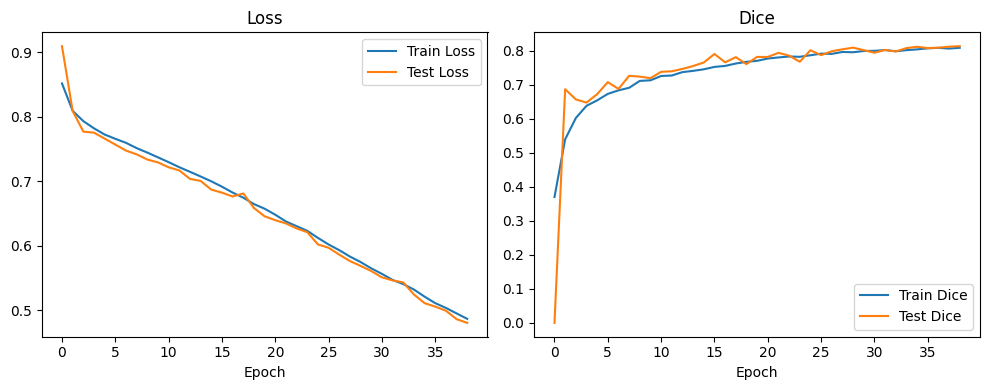

In [ ]:
# ---- Plot curves ----
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["test_loss"],  label="Test Loss")
plt.title("Loss"); plt.xlabel("Epoch"); plt.legend()

plt.subplot(1,2,2)
plt.plot(history["train_dice"], label="Train Dice")
plt.plot(history["test_dice"],  label="Test Dice")
plt.title("Dice"); plt.xlabel("Epoch"); plt.legend()
plt.tight_layout(); plt.show()


# **🩺 Model Evaluation & Test Predictions**

After training our **Attention U-Net (AttnUNet)**, we now move to the final stage:  
evaluating the model on the **unseen test set** and visualizing its predictions.

---

## 🔹 Step 1: Load the Best Model
We load the best checkpoint (`best_attnunet.pth`) and re-evaluate it on the test dataset.  
The evaluation includes multiple metrics:

- **Loss** → Measures how well the model fits the data.  
- **Dice Score** → Captures overlap between predicted and ground truth masks.  
- **IoU (Intersection over Union)** → Another overlap-based segmentation metric.  
- **Accuracy** → Proportion of correctly predicted pixels.  
- **AUC (Area Under Curve)** → Measures the quality of probabilistic predictions.

---

## 🔹 Step 2: Define Prediction Function
We define `predict_prob_mask(img_t)`:
1. Forward pass through the model → logits.
2. Apply **sigmoid** to get probabilities.
3. Apply a **0.5 threshold** → binary segmentation mask.  

This gives us both:
- Probability map (soft prediction).
- Binary mask (hard prediction).

---

## 🔹 Step 3: Visualization of Predictions
To better understand performance, we visualize predictions using `show_test_predictions(ds, n=6)`:
- Randomly selects `n` samples from the test dataset.  
- Displays 4 panels for each sample:
  1. **Original Image**
  2. **Ground Truth Mask**
  3. **Predicted Probability Map**
  4. **Overlay of Prediction on Original Image**

This allows qualitative comparison between the ground truth and predicted masks.

---

## 🔹 Step 4: Run Visualization
Finally, we display results by running:

```python
show_test_predictions(test_ds, n=6)


[FINAL TEST] loss=0.4802 | dice=0.8129 | iou=0.6850 | acc=0.9674 | auc=0.9727


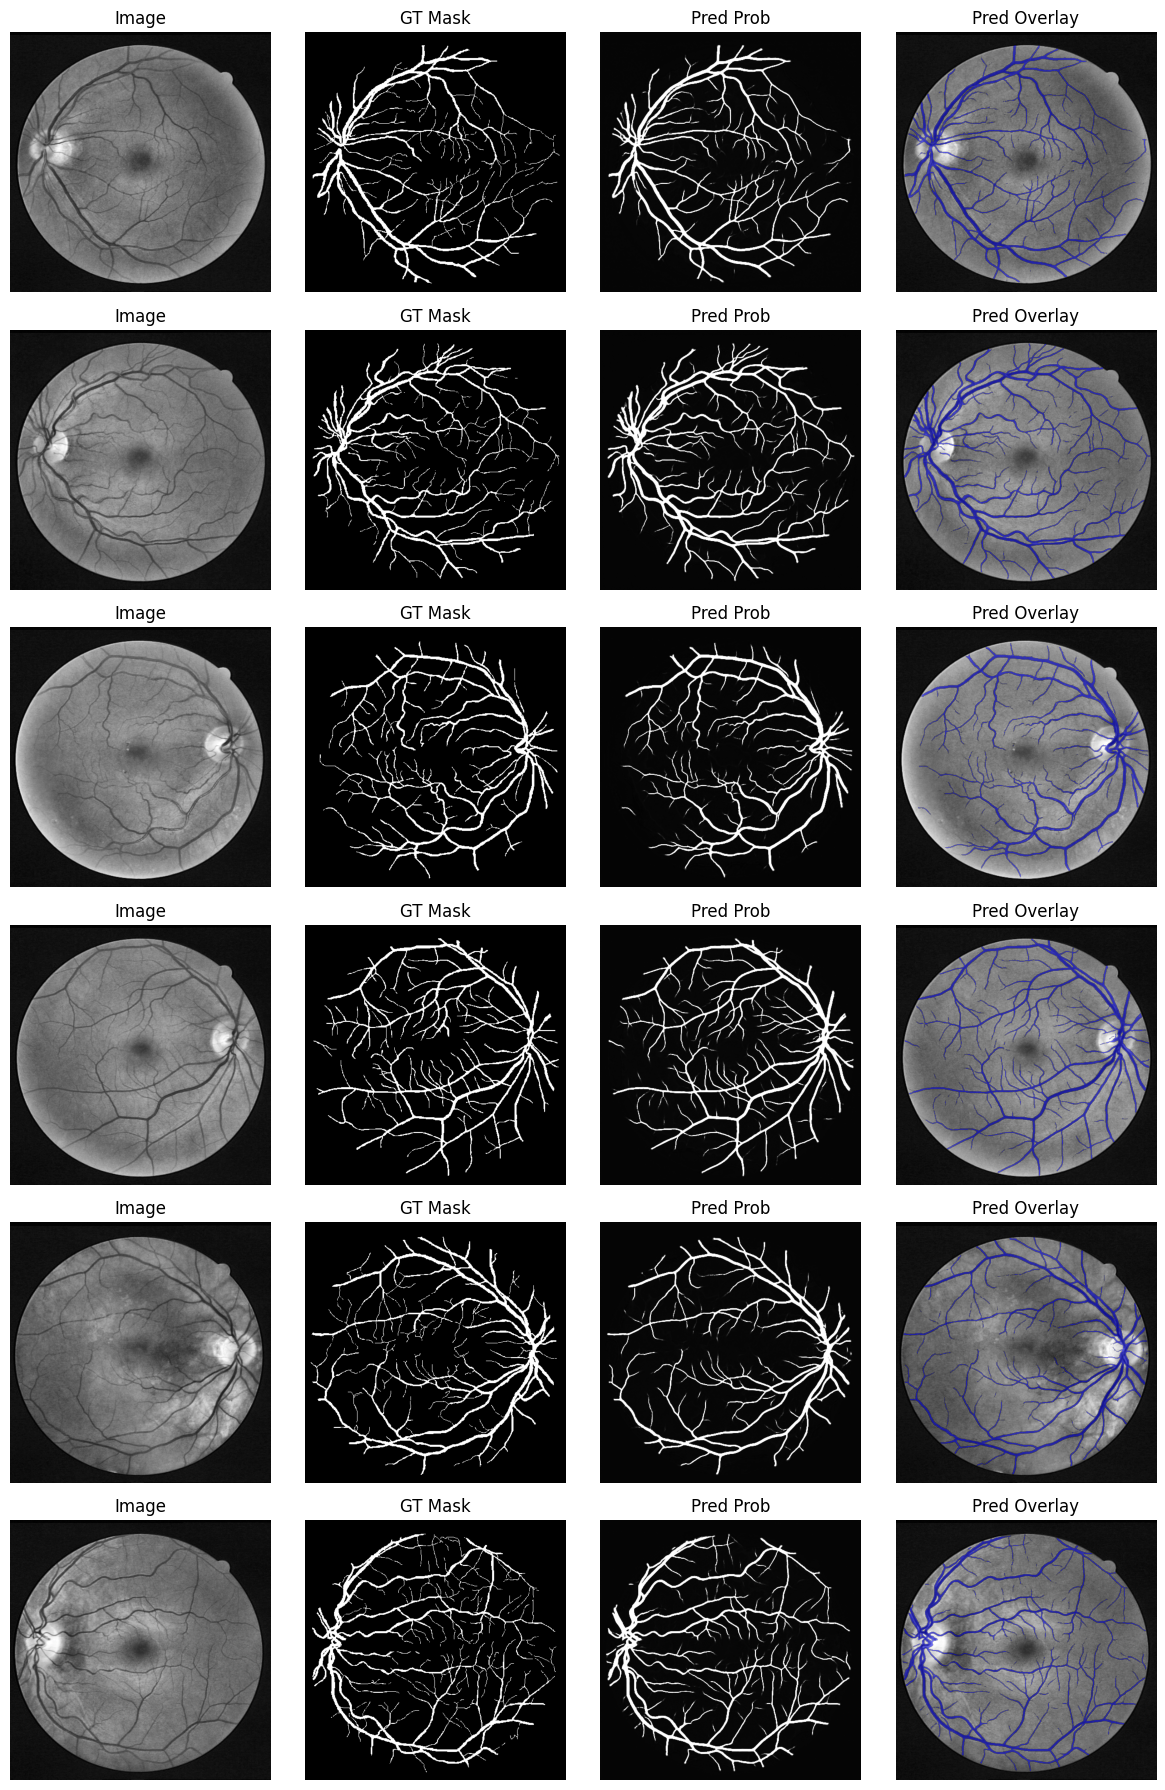

In [ ]:
# Load best model and re-evaluate on test set
ckpt = "best_attnunet.pth"
assert os.path.isfile(ckpt), "No checkpoint found. Train first."
model = AttnUNet(in_ch=1, out_ch=1).to(DEVICE)
model.load_state_dict(torch.load(ckpt, map_location=DEVICE))
model.eval()

test_loss, test_dice, test_iou, test_acc, test_auc = eval_epoch(model, test_loader, loss_fn)
print(f"[FINAL TEST] loss={test_loss:.4f} | dice={test_dice:.4f} | iou={test_iou:.4f} | acc={test_acc:.4f} | auc={test_auc:.4f}")

@torch.no_grad()
def predict_prob_mask(img_t):
    x = img_t.unsqueeze(0).to(DEVICE)      # [1,1,H,W]
    logits = model(x)
    prob = torch.sigmoid(logits)[0,0].cpu().numpy()
    pred = (prob > 0.5).astype(np.float32)
    return prob, pred

def show_test_predictions(ds, n=6):
    import numpy as np
    idxs = random.sample(range(len(ds)), k=min(n, len(ds)))
    fig, axes = plt.subplots(len(idxs), 4, figsize=(12, 3*len(idxs)))
    if len(idxs)==1: axes = np.expand_dims(axes,0)
    for r, i in enumerate(idxs):
        img_t, msk_t = ds[i]
        prob, pred = predict_prob_mask(img_t)
        img = denorm_img(img_t[0]).cpu().numpy()
        gt  = msk_t[0].cpu().numpy()

        axes[r,0].imshow(img, cmap="gray"); axes[r,0].set_title("Image"); axes[r,0].axis("off")
        axes[r,1].imshow(gt, cmap="gray");  axes[r,1].set_title("GT Mask"); axes[r,1].axis("off")
        axes[r,2].imshow(prob, cmap="gray");axes[r,2].set_title("Pred Prob"); axes[r,2].axis("off")
        axes[r,3].imshow(img, cmap="gray")
        axes[r,3].imshow(np.ma.masked_where(pred==0, pred), alpha=0.5, cmap="winter")
        axes[r,3].set_title("Pred Overlay"); axes[r,3].axis("off")
    plt.tight_layout(); plt.show()

show_test_predictions(test_ds, n=6)
